### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Rescorla-Wagner reinforcement learning model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../..')
from pyEM.fitting import EMfit
from pyEM.math import norm2beta, alpha2norm, beta2norm, compGauss_ms, calc_BICint, calc_LME
from pyEM import plotting
import rw3_models

In [4]:
modelID = 'RW'
param_names = ['beta', 'lr', 'rew_sensitivity']
objfunc_dict = {modelID: rw3_models.fit}
simul_dict   = {modelID: rw3_models.simulate}

nsubjects = 150
betamin, betamax   = .75,  10
alphamin, alphamax = .05, .95
rsmin, rsmax = .05, .95

params = np.ones((nsubjects, 3))
for simS in tqdm(range(nsubjects)):
    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm2beta(norm.rvs(0, scale=1))

    # For alpha, we will sample from a beta distribution and then transform
    params[simS, 1] = beta.rvs(1.1, 1.1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = beta.rvs(1.1, 1.1)

    # For reward sensitivity, we will sample from a gaussian distribution at .5
    params[simS, 2] = norm.rvs(.5, scale=1)
    while params[simS, 2] > rsmax or params[simS, 2] < rsmin:
        params[simS, 2] = norm.rvs(.5, scale=1)

100%|██████████| 150/150 [00:00<00:00, 4838.58it/s]


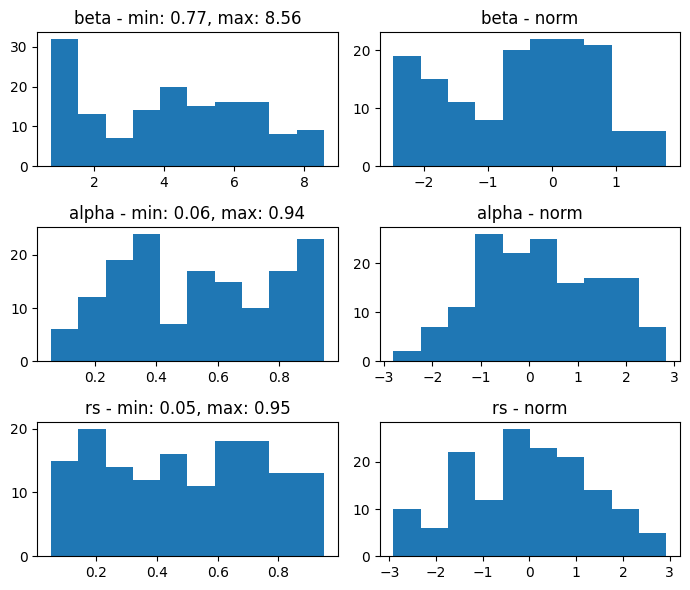

In [5]:
# plot 2 x 2
plt.figure(figsize=(7, 6))
plt.subplot(321)
plt.hist(params[:,0]);
plt.title(f'beta - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(322)
plt.hist(beta2norm(params[:,0]));
plt.title(f'beta - norm');

plt.subplot(323)
plt.hist(params[:,1]);
plt.title(f'alpha - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

plt.subplot(324)
plt.hist(alpha2norm(params[:,1]));
plt.title(f'alpha - norm');

plt.subplot(325)
plt.hist(params[:,2]);
plt.title(f'rs - min: {min(params[:,2]):.2f}, max: {max(params[:,2]):.2f}');

plt.subplot(326)
plt.hist(alpha2norm(params[:,2]));
plt.title(f'rs - norm');

plt.tight_layout()

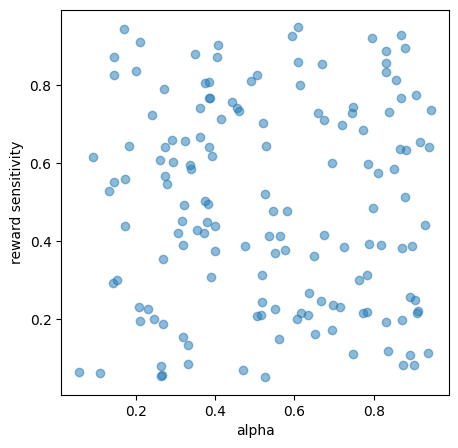

In [6]:
# plot scatter between lr and rew_sensitivity
plt.figure(figsize=(5, 5))
plt.scatter(params[:,1], params[:,2], alpha=.5)
plt.xlabel('alpha')
plt.ylabel('reward sensitivity')
plt.show()

In [7]:
ntrials, nblocks = 24, 6
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict['RW']
subj_dict = simulfunc(params, nblocks=nblocks, ntrials=ntrials)

ntrials: 24, nblocks: 6


In [8]:
print(subj_dict.keys())

dict_keys(['params', 'choices', 'rewards', 'EV', 'CH_PROB', 'CHOICES_A', 'PE', 'CHOICE_NLL'])


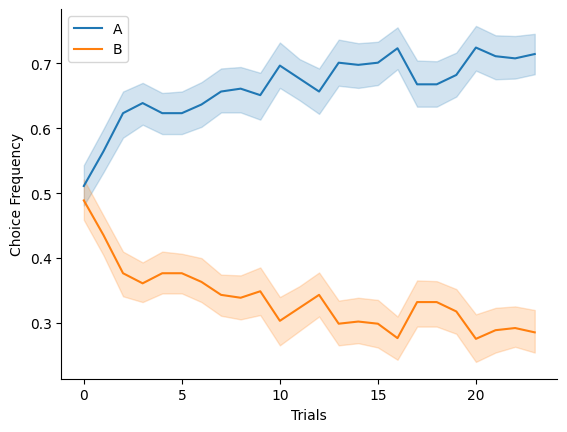

In [9]:
plotting.plot_choices(subj_dict['CHOICES_A']) 

In [10]:
# create a list of lists with choices and rewards for each subject
all_data = []
for idx, (choices, rewards) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'])):
    all_data += [[choices, rewards]]

In [12]:
output_dict = EMfit(all_data, objfunc_dict['RW'], param_names, mstep_maxit=200)
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = output_dict.values()

16177.030 (000), 12664.191 (001), 12536.029 (002), 12489.136 (003), 12468.377 (004), 12457.905 (005), 12451.957 (006), 12448.695 (007), 12446.870 (008), 12445.418 (009), 12444.734 (010), 12444.271 (011), 12443.549 (012), 12442.915 (013), 12442.712 (014), 12442.653 (015), 12442.595 (016), 12442.259 (018), 12442.224 (019), -MAXIMUM NUMBER OF ITERATIONS REACHED



In [13]:
## Now store all relevant outputs in modfit_dict and save
modfit_dict = {}
modfit_dict['norm_params'] = m.T.copy()
modfit_dict['est_params'] = m.T.copy()
modfit_dict['param_names'] = param_names
modfit_dict['inverse_hess'] = inv_h
modfit_dict['gauss.mu'] = posterior['mu']
modfit_dict['gauss.sigma'] = posterior['sigma']
modfit_dict['NPL'] = NPL  # note: this is the negative joint posterior likelihood
modfit_dict['NLPrior'] = NLPrior
modfit_dict['NLL'] = NPL - NLPrior

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2) 
modfit_dict['gauss.cov'] = covmat_out
try:
    modfit_dict['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modfit_dict['gauss.corr'] = np.eye(len(param_names))

# Calculate integrated BIC
modfit_dict['BICint'] = calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw3_models.fit, nll_output='CHOICE_NLL')

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL)
modfit_dict['Laplace_approx'] = Laplace_approx
modfit_dict['lme'] = lme
modfit_dict['goodHessian'] = goodHessian

# Get subject specific fits
modfit_dict['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modfit_dict['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['EV']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modfit_dict['CH_PROB']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modfit_dict['CHOICES_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['PE']          = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['CHOICE_NLL']       = np.zeros((nsubjects,))

for subj_idx in range(nsubjects):

    # get info for current subject
    choices = subj_dict['choices'][subj_idx,:,:]
    rewards = subj_dict['rewards'][subj_idx,:,:]
    subj_fit = rw3_models.fit(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modfit_dict['est_params'][subj_idx,:] = subj_fit['params']
    modfit_dict['choices'][subj_idx,:,:] = subj_fit['choices']
    modfit_dict['rewards'][subj_idx,:,:] = subj_fit['rewards']
    modfit_dict['EV'][subj_idx,:,:,:] = subj_fit['EV']
    modfit_dict['CH_PROB'][subj_idx,:,:,:] = subj_fit['CH_PROB']
    modfit_dict['CHOICES_A'][subj_idx,:,:] = subj_fit['CHOICES_A']
    modfit_dict['PE'][subj_idx,:,:] = subj_fit['PE']
    modfit_dict['CHOICE_NLL'][subj_idx] = subj_fit['CHOICE_NLL']

# Save output
save_fit = False
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modfit_dict, f)

Good Hessians: 150 out of 150


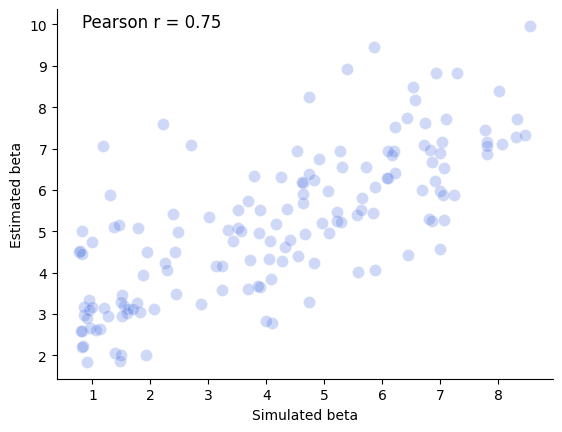

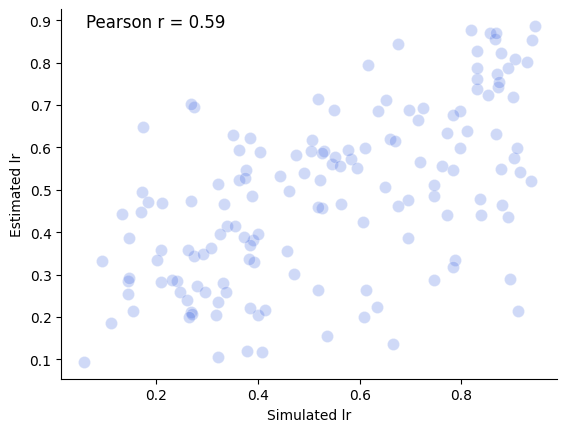

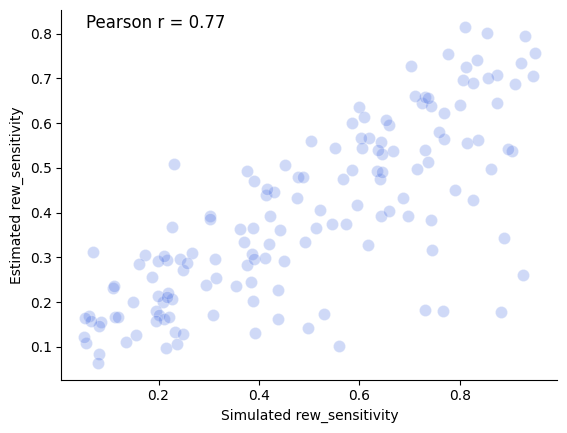

In [14]:
# show parameter recovery
for param_idx, param_label in enumerate(param_names):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = modfit_dict['est_params'][:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

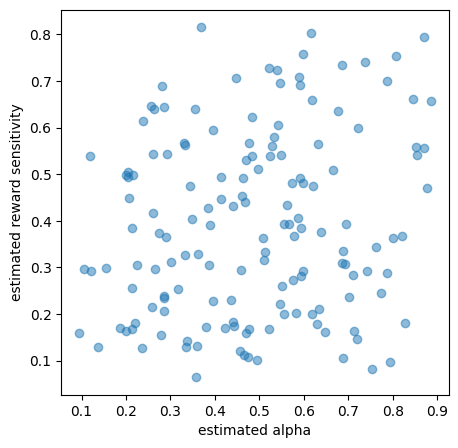

In [15]:
# plot scatter between lr and rew_sensitivity
plt.figure(figsize=(5, 5))
plt.scatter(modfit_dict['est_params'][:,1], modfit_dict['est_params'][:,2], alpha=.5)
plt.xlabel('estimated alpha')
plt.ylabel('estimated reward sensitivity')
plt.show()